#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/3_project/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [5]:
data = pd.read_csv(path + 'data01_train.csv')

In [6]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [7]:
data.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS
5880,0.283815,-0.040658,-0.138018,-0.992662,-0.747190,-0.920248,-0.993410,-0.768055,-0.924587,-0.935871,...,-0.696584,0.107690,0.122242,-0.077226,-0.078091,-0.740244,0.008346,-0.146143,29,SITTING


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [8]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [11]:
df = data

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [10]:
target = 'Activity'

In [12]:
# 범주의 종류 확인
categories = df[target].unique()

# 범주별 빈도수 계산
category_counts = df[target].value_counts()

# 범주별 비율 계산
category_percentage = df[target].value_counts(normalize=True) * 100

# 결과 출력
print("범주의 종류:")
print(categories)

print("\n범주별 빈도수:")
print(category_counts)

print("\n범주별 비율(%):")
print(category_percentage)

범주의 종류:
['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']

범주별 빈도수:
Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

범주별 비율(%):
Activity
LAYING                18.959361
STANDING              18.483251
SITTING               17.548036
WALKING               16.969903
WALKING_UPSTAIRS      14.589356
WALKING_DOWNSTAIRS    13.450094
Name: proportion, dtype: float64


<Axes: title={'center': '범주별 빈도수'}, xlabel='Activity', ylabel='Count'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*ar

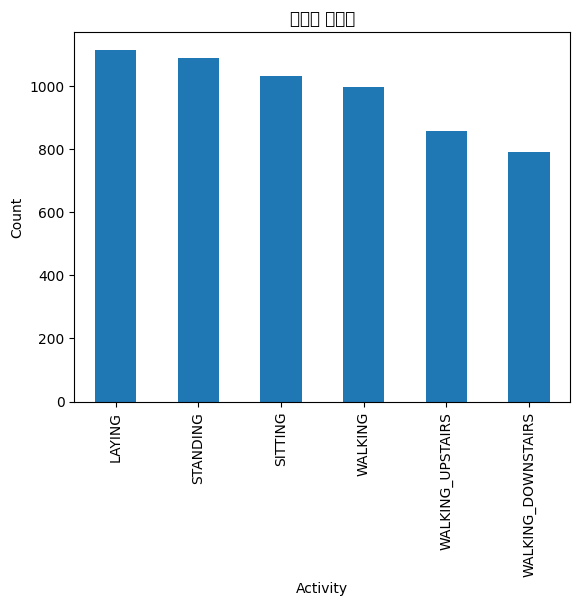

In [14]:
# 시각화

df[target].value_counts().plot(kind='bar', title='범주별 빈도수', xlabel='Activity', ylabel='Count')


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [202]:

# x, y 나누기
# x = df.drop(target, axis=1)
# y = df.loc[:, target]

#  분할
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# subject를 기준으로 데이터 나누기
# x_train_2 = df[df['subject'] <= 26].drop(columns=['Activity', 'subject'])
# y_train_2 = df[df['subject'] <= 26]['Activity']

# x_val_2 = df[df['subject'] > 26].drop(columns=['Activity', 'subject'])
# y_val_2 = df[df['subject'] > 26]['Activity']

# subject를 기준으로 데이터 나누기 (LAYING, STANDING, SITTING 제외)
x_train_3 = df[(df['subject'] <= 26) & (~df['Activity'].isin(['LAYING', 'STANDING', 'SITTING']))].drop(columns=['is_dynamic', 'Activity', 'subject'])
y_train_3 = df[(df['subject'] <= 26) & (~df['Activity'].isin(['LAYING', 'STANDING', 'SITTING']))]['Activity']

x_val_3 = df[(df['subject'] > 26) & (~df['Activity'].isin(['LAYING', 'STANDING', 'SITTING']))].drop(columns=['is_dynamic', 'Activity', 'subject'])
y_val_3 = df[(df['subject'] > 26) & (~df['Activity'].isin(['LAYING', 'STANDING', 'SITTING']))]['Activity']

# 랜덤포레스트 모델 생성
rf_model_3 = RandomForestClassifier(random_state=42)

# 모델 학습
rf_model_3.fit(x_train_3, y_train_3)

# 검증 데이터로 예측
y_pred_3 = rf_model_3.predict(x_val_3)

# 분류 보고서 출력
report_3 = classification_report(y_val_3, y_pred_3)
print("분류 보고서:\n", report_3)


분류 보고서:
                     precision    recall  f1-score   support

           WALKING       0.98      0.99      0.99       181
WALKING_DOWNSTAIRS       0.99      0.96      0.97       161
  WALKING_UPSTAIRS       0.97      0.99      0.98       164

          accuracy                           0.98       506
         macro avg       0.98      0.98      0.98       506
      weighted avg       0.98      0.98      0.98       506



In [203]:
importances_3 = rf_model_3.feature_importances_
features_3 = x_train_3.columns


feature_importance_df_3 = plot_feature_importance(importances_3, features_3)


top30_features_3 = feature_importance_df_3['feature_name'].head(30)
top30_features_3

df_filtered = df[~df['Activity'].isin(['LAYING', 'STANDING', 'SITTING'])]

for feature in top30_features_3:
  plt.figure(figsize=(12, 4))
  sns.kdeplot(data=df_filtered, x=feature, hue=target, fill=True, common_norm=False, alpha=0.5)
  plt.title(f"KDE Plot of {feature} by {target}")
  plt.xlabel(feature)
  plt.ylabel('Density')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [128]:
y_val_2.head()

,Activity
6,WALKING
16,WALKING_UPSTAIRS
24,WALKING
25,STANDING
26,WALKING


#### 2) 모델링

In [74]:
rf_model = RandomForestClassifier(random_state=42)

# 모델 학습
rf_model.fit(x_train, y_train)

# 검증 데이터로 예측
y_pred = rf_model.predict(x_val)

# 정확도 출력
report = classification_report(y_val, y_pred)
print("분류 보고서", report)

분류 보고서                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       231
           SITTING       0.97      0.98      0.97       200
          STANDING       0.98      0.97      0.98       226
           WALKING       0.99      0.99      0.99       198
WALKING_DOWNSTAIRS       0.99      0.98      0.98       145
  WALKING_UPSTAIRS       0.99      0.99      0.99       177

          accuracy                           0.99      1177
         macro avg       0.99      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



In [92]:
rf_model_2 = RandomForestClassifier(random_state=42)

# 모델 학습
rf_model_2.fit(x_train_2, y_train_2)

# 검증 데이터로 예측
y_pred_2 = rf_model_2.predict(x_val_2)

# 정확도 출력
report_2 = classification_report(y_val_2, y_pred_2)
print("분류 보고서", report_2)

분류 보고서                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       229
           SITTING       0.87      0.86      0.87       207
          STANDING       0.88      0.88      0.88       230
           WALKING       0.98      0.99      0.99       181
WALKING_DOWNSTAIRS       1.00      0.96      0.98       161
  WALKING_UPSTAIRS       0.97      0.99      0.98       164

          accuracy                           0.95      1172
         macro avg       0.95      0.95      0.95      1172
      weighted avg       0.95      0.95      0.95      1172



#### 3) 변수 중요도 추출

In [103]:
# 변수 중요도
# importances = rf_model.feature_importances_
# features = x.columns

importances_2 = rf_model_2.feature_importances_
features_2 = x_train_2.columns

print(len(importances_2))
print(len(features_2))

561
561


In [88]:
# features

len(features_2)

562

### 변수중요도 함수 사용

In [105]:
feature_importance_df = plot_feature_importance(importances, features)

feature_importance_df_2 = plot_feature_importance(importances_2, features_2)

Output hidden; open in https://colab.research.google.com to view.

In [106]:
feature_importance_df.head()

,feature_name,feature_importance
0,tGravityAcc-mean()-X,0.033213
1,tGravityAcc-max()-Y,0.029725
2,tGravityAcc-max()-X,0.026256
3,tGravityAcc-min()-X,0.025537
4,"angle(X,gravityMean)",0.024184


In [107]:
feature_importance_df_2.head()

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.033023
1,tGravityAcc-mean()-X,0.031263
2,tGravityAcc-mean()-Y,0.027796
3,tGravityAcc-max()-X,0.027353
4,tGravityAcc-min()-Y,0.024717


In [67]:
feature_importance_df.tail()

,feature_name,feature_importance
557,"fBodyGyro-bandsEnergy()-49,56.1",0.000102
558,fBodyAcc-entropy()-Y,0.000101
559,tBodyAccJerkMag-arCoeff()3,0.000075
560,fBodyAccJerk-entropy()-Y,0.000062
561,tBodyAccJerkMag-max(),0.000037


In [108]:
feature_importance_df_2.tail()

,feature_name,feature_importance
556,tBodyAccJerk-mean()-Y,0.000094
557,"fBodyAccJerk-bandsEnergy()-49,64",0.000091
558,"fBodyGyro-bandsEnergy()-33,48.1",0.000083
559,"fBodyAcc-bandsEnergy()-33,40.1",0.000071
560,"fBodyAcc-bandsEnergy()-49,64.2",0.000066


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [190]:
top5_features = feature_importance_df['feature_name'].head(30)
top5_features

top5_features_2 = feature_importance_df_2['feature_name'].head(30)
top5_features_2

,feature_name
0,"angle(X,gravityMean)"
1,tGravityAcc-mean()-X
2,tGravityAcc-mean()-Y
3,tGravityAcc-max()-X
4,tGravityAcc-min()-Y
5,tGravityAcc-min()-X
6,tGravityAcc-energy()-X
7,tGravityAcc-max()-Y
8,tGravityAcc-energy()-Y
9,"angle(Y,gravityMean)"


In [114]:
bottom5_features = feature_importance_df['feature_name'].tail(5)
bottom5_features_reversed = bottom5_features[::-1]
bottom5_features_reversed

bottom5_features_2 = feature_importance_df_2['feature_name'].tail(5)
bottom5_features_reversed_2 = bottom5_features_2[::-1]
bottom5_features_reversed_2

,feature_name
560,"fBodyAcc-bandsEnergy()-49,64.2"
559,"fBodyAcc-bandsEnergy()-33,40.1"
558,"fBodyGyro-bandsEnergy()-33,48.1"
557,"fBodyAccJerk-bandsEnergy()-49,64"
556,tBodyAccJerk-mean()-Y


#### 2) 상위 5개 변수에 대한 분석

In [191]:
for feature_left, feature_right in zip(top5_features, top5_features_2):
    # 각각의 figure를 생성하고 크기 설정
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 왼쪽 그래프 (bottom5_features_reversed)
    sns.kdeplot(data=df, x=feature_left, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[0])
    axes[0].set_title(f"KDE Plot of {feature_left} by {target}")
    axes[0].set_xlabel(feature_left)
    axes[0].set_ylabel('Density')

    # 오른쪽 그래프 (bottom5_features_reversed_2)
    sns.kdeplot(data=df, x=feature_right, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[1])
    axes[1].set_title(f"KDE Plot of {feature_right} by {target}")
    axes[1].set_xlabel(feature_right)
    axes[1].set_ylabel('Density')

    # 그래프 간격 조정 및 출력
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

#### 3) 하위 5개 변수에 대한 분석

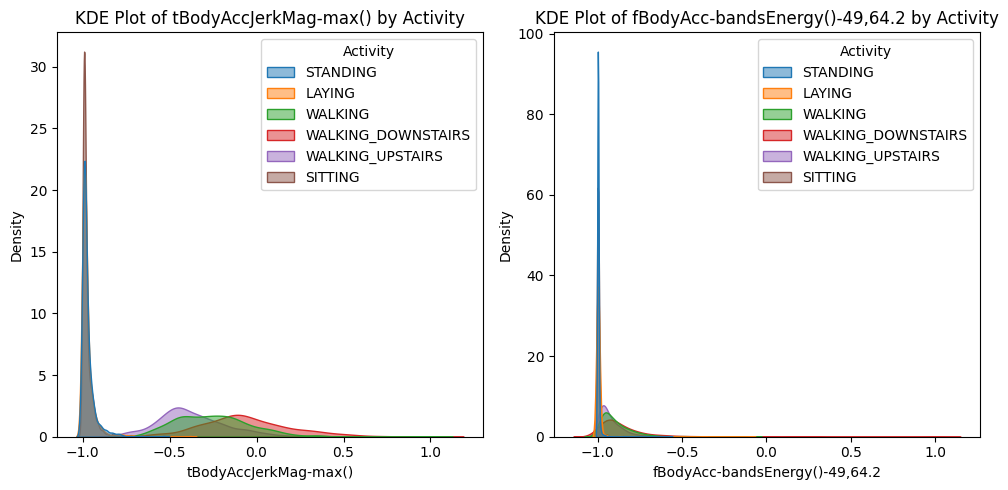

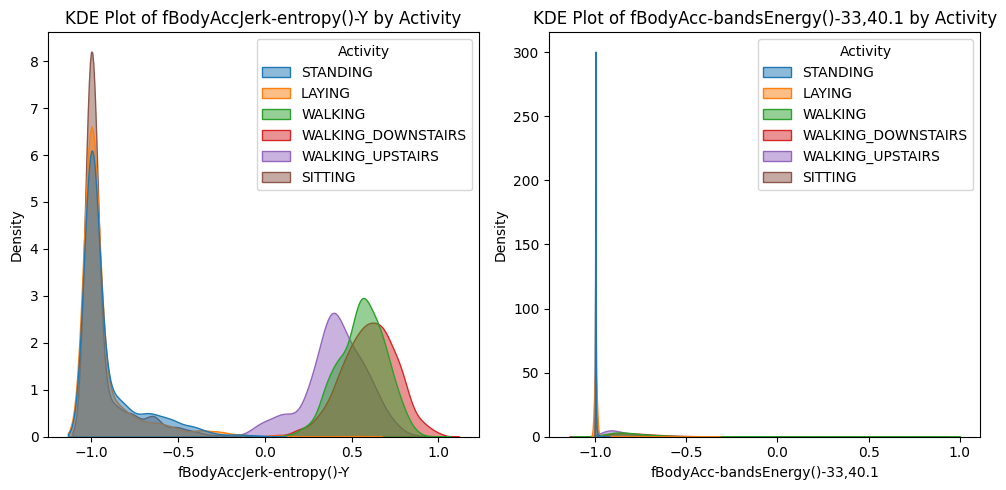

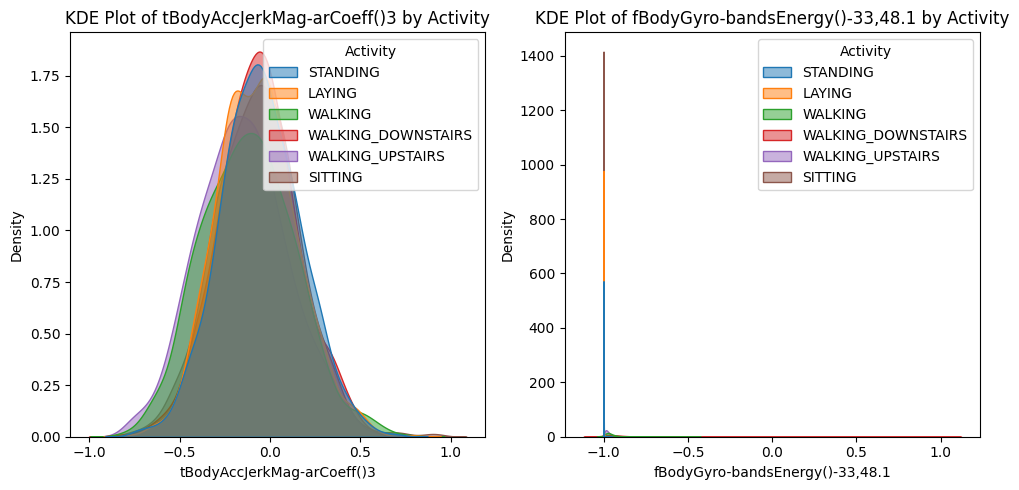

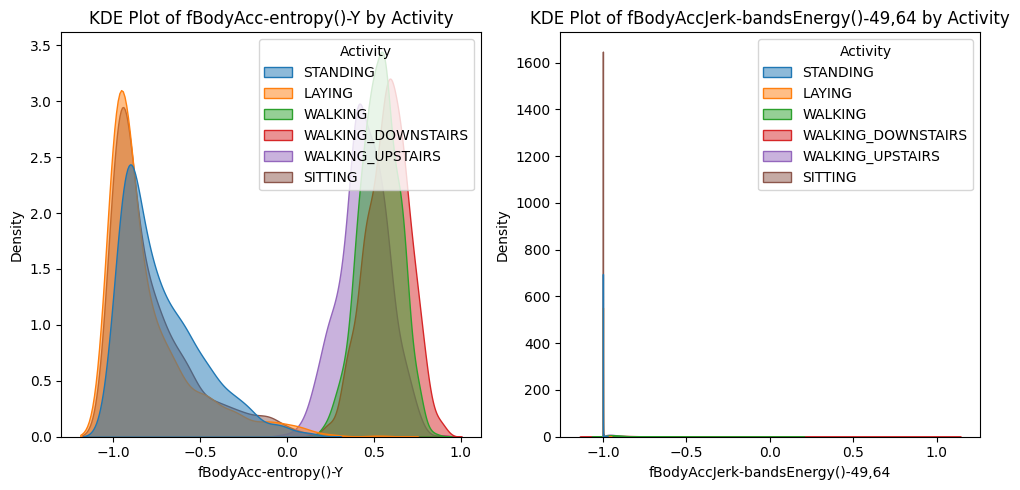

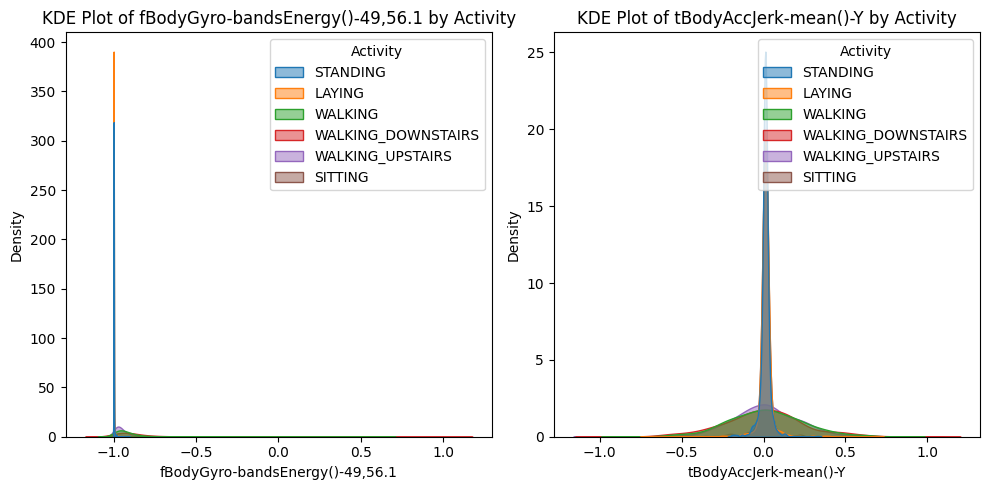

In [117]:
for feature_left, feature_right in zip(bottom5_features_reversed, bottom5_features_reversed_2):
    # 각각의 figure를 생성하고 크기 설정
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # 왼쪽 그래프 (bottom5_features_reversed)
    sns.kdeplot(data=df, x=feature_left, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[0])
    axes[0].set_title(f"KDE Plot of {feature_left} by {target}")
    axes[0].set_xlabel(feature_left)
    axes[0].set_ylabel('Density')

    # 오른쪽 그래프 (bottom5_features_reversed_2)
    sns.kdeplot(data=df, x=feature_right, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[1])
    axes[1].set_title(f"KDE Plot of {feature_right} by {target}")
    axes[1].set_xlabel(feature_right)
    axes[1].set_ylabel('Density')

    # 그래프 간격 조정 및 출력
    plt.tight_layout()
    plt.show()


## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [122]:
# is_dynamic
df['is_dynamic'] = df['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

In [123]:
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [147]:
# x, is_dynamic을 이용하여 train과 validation으로 분할 (subject 기준)
x_train = df[df['subject'] <= 24].drop(columns=['Activity', 'subject', 'is_dynamic'])
y_train = df[df['subject'] <= 24]['is_dynamic']

x_val = df[df['subject'] > 24].drop(columns=['Activity', 'subject', 'is_dynamic'])
y_val = df[df['subject'] > 24]['is_dynamic']

In [148]:
x_val.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.127764,-0.371055,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627
16,0.407780,-0.053721,-0.160671,-0.321271,-0.089818,0.173128,-0.394279,-0.095346,0.205751,0.013823,...,0.061631,-0.240452,-0.644600,-0.593603,0.547782,0.535282,-0.081472,-0.802731,0.234439,0.013737
23,0.328761,-0.019217,-0.095479,-0.181639,-0.108235,-0.482251,-0.205424,-0.101455,-0.446708,0.021239,...,0.123558,-0.418387,-0.725248,-0.800552,-0.786350,-0.930323,-0.563528,-0.899577,0.149138,-0.031913
24,0.309974,-0.043633,-0.123312,-0.127170,0.086390,-0.204899,-0.139884,0.063893,-0.220632,0.070088,...,-0.042087,-0.129624,-0.549165,-0.415788,0.643363,-0.830801,-0.735993,-0.760490,0.238808,0.107779
25,0.288593,0.007488,-0.087689,-0.992753,-0.961603,-0.964807,-0.993817,-0.961010,-0.966279,-0.934038,...,0.351584,-0.575164,-0.857957,0.033677,0.128880,-0.402235,0.031967,-0.771732,0.255730,0.010392


In [160]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(x_train, y_train)

# 검증 데이터로 예측
y_pred = rf_model.predict(x_val)

# 분류 보고서 출력 (정밀도, 재현율, F1 점수)
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       999
           1       1.00      0.96      0.98       801

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [161]:
importances = rf_model.feature_importances_
features = x_train.columns

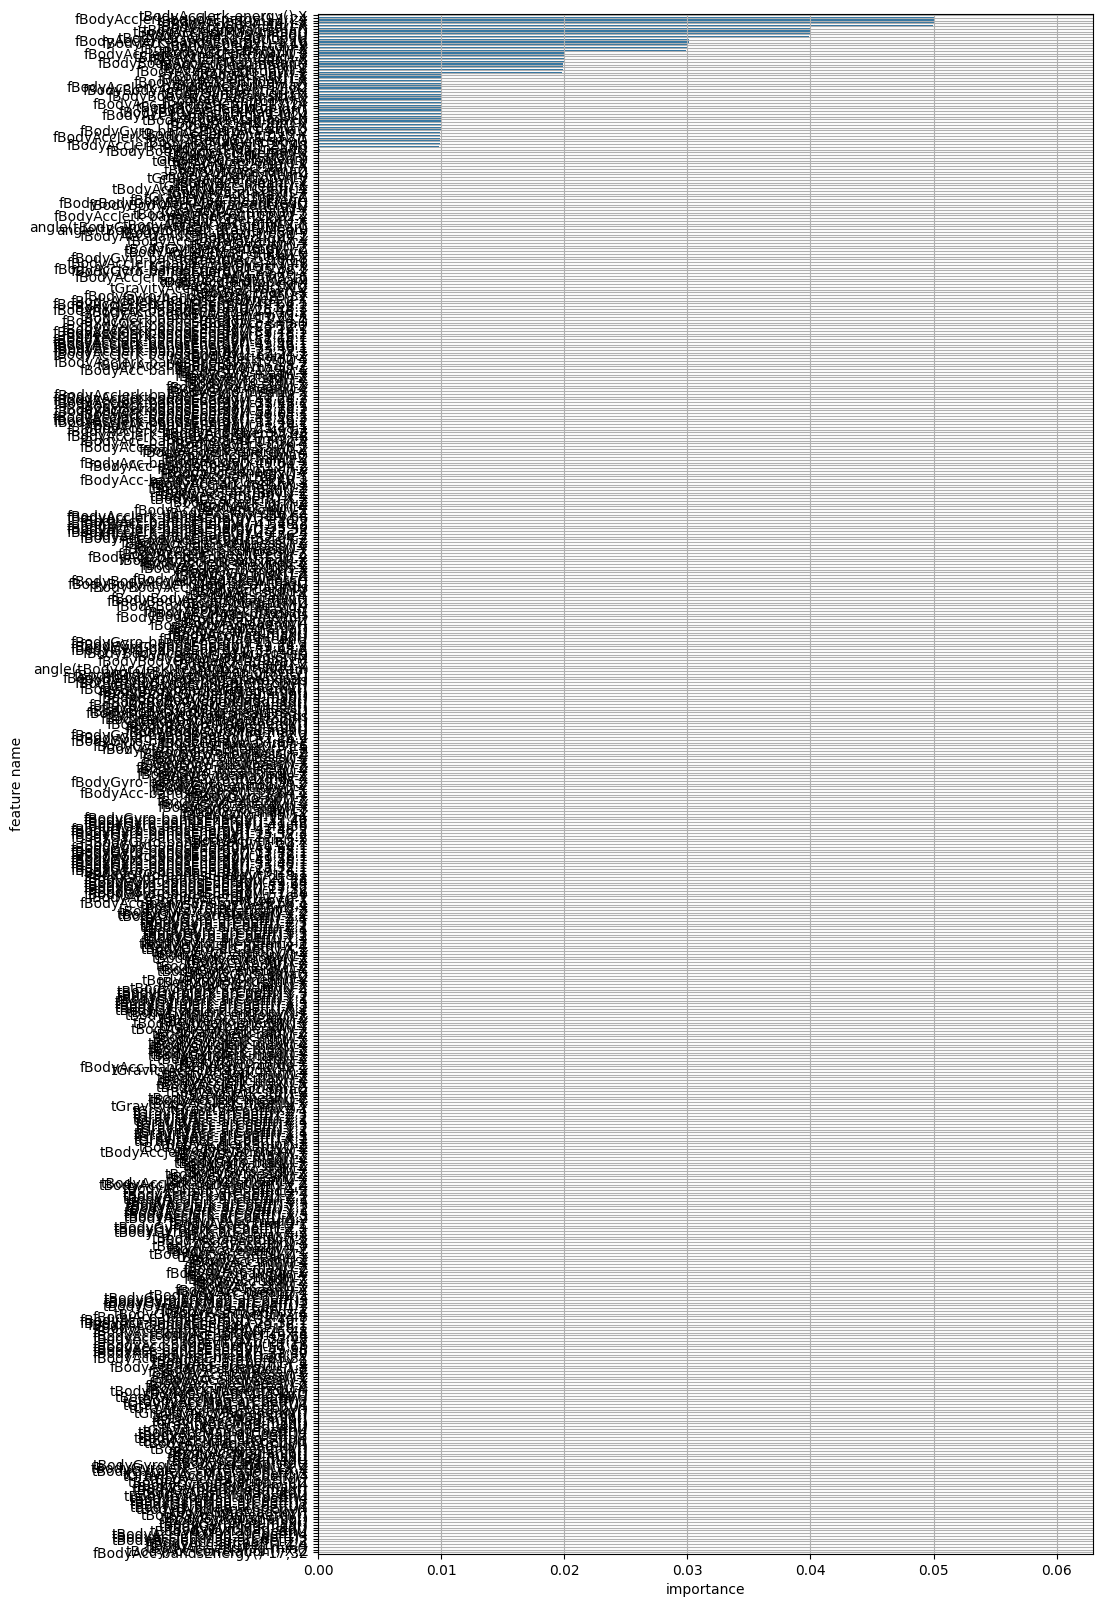

In [162]:
feature_importance_df = plot_feature_importance(importances, features)


#### 3) 변수중요도 상위 5개 분석

In [163]:
feature_importance_df.head(20)

,feature_name,feature_importance
0,tBodyAccJerk-energy()-X,0.059970
1,"fBodyAccJerk-bandsEnergy()-1,24",0.050049
2,tBodyAccJerk-mad()-X,0.050000
3,fBodyAccJerk-std()-X,0.050000
4,fBodyAccJerk-mad()-X,0.049970
5,tBodyAccJerkMag-sma(),0.040079
6,tBodyAccJerkMag-mean(),0.039960
7,tBodyAccJerkMag-mad(),0.039941
8,tBodyAccJerkMag-entropy(),0.039872
9,"fBodyAccJerk-bandsEnergy()-1,16",0.030158


In [164]:
top5_features = feature_importance_df['feature_name'].head(5)
top5_features

,feature_name
0,tBodyAccJerk-energy()-X
1,"fBodyAccJerk-bandsEnergy()-1,24"
2,tBodyAccJerk-mad()-X
3,fBodyAccJerk-std()-X
4,fBodyAccJerk-mad()-X


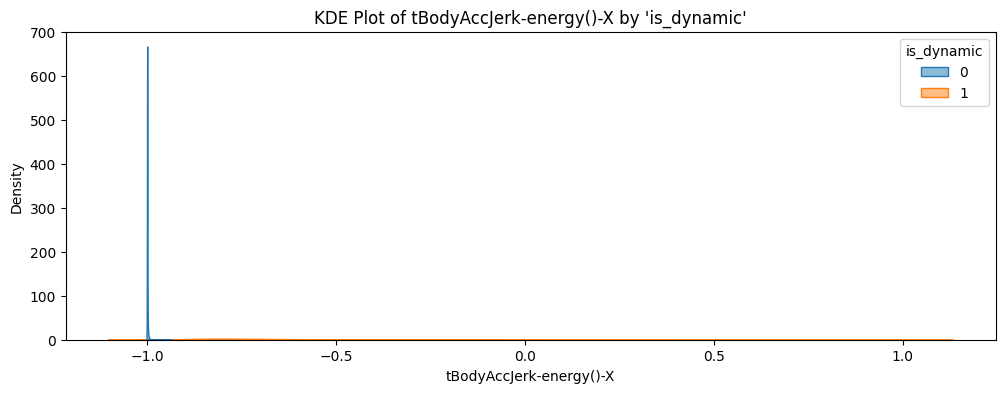

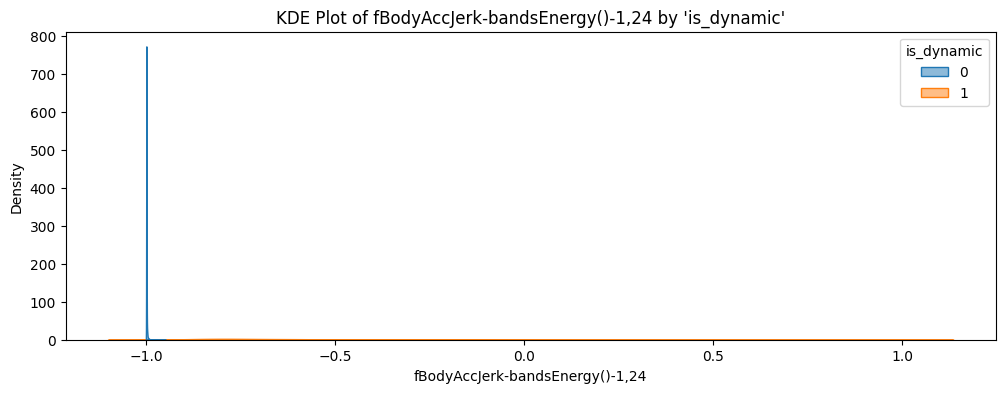

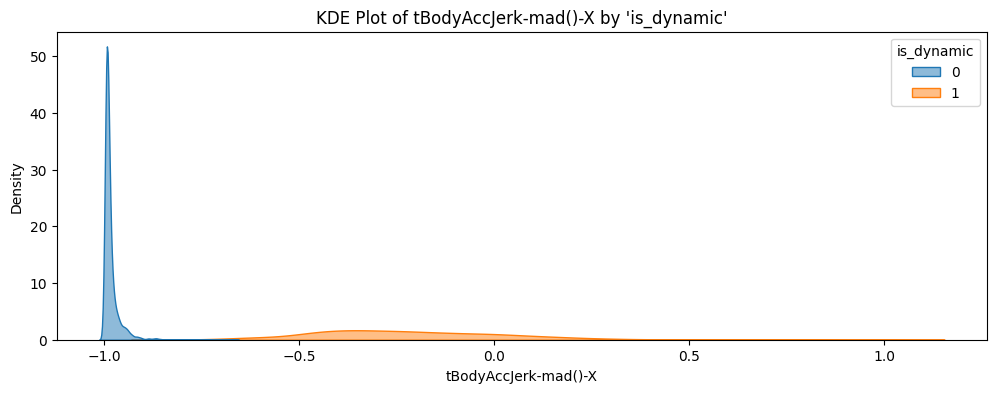

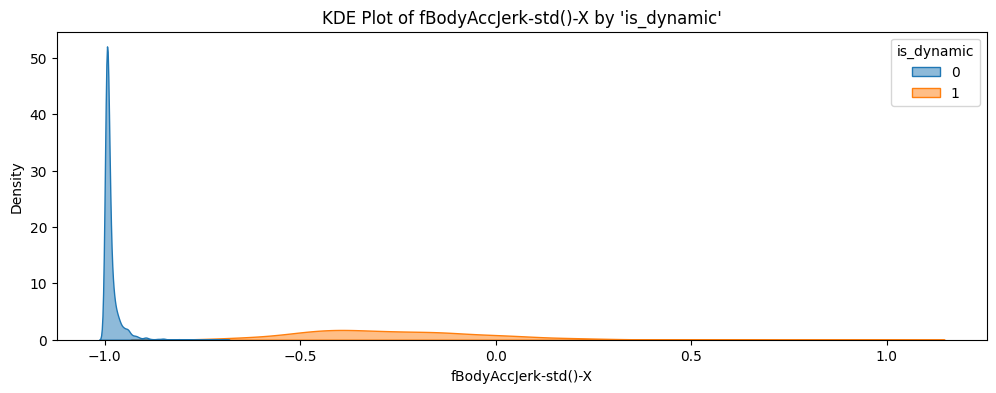

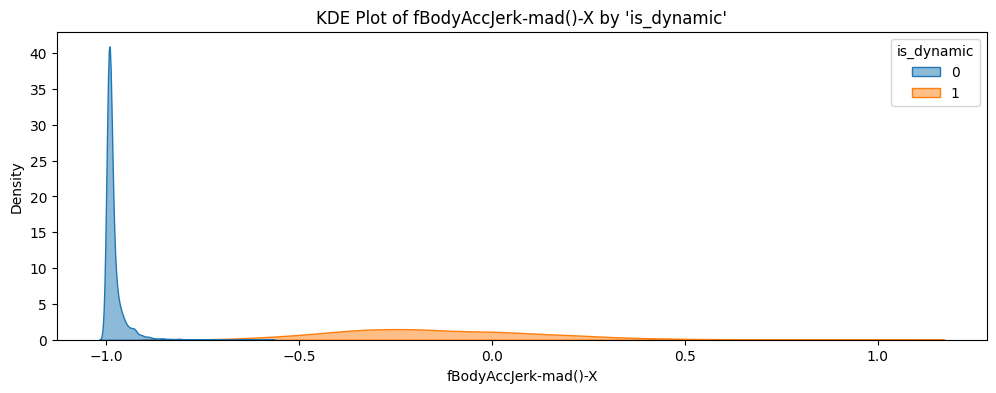

In [166]:
for feature in top5_features:
  plt.figure(figsize=(12, 4))
  sns.kdeplot(data=df, x=feature, hue='is_dynamic', fill=True, common_norm=False, alpha=0.5)
  plt.title(f"KDE Plot of {feature} by 'is_dynamic'")
  plt.xlabel(feature)
  plt.ylabel('Density')
  plt.show()

In [177]:
y_data = pd.read_csv(path + 'data01_test.csv')

In [178]:
y_df = y_data

In [182]:
y_df.tail()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,14,SITTING,0
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,16,STANDING,0
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,8,WALKING_DOWNSTAIRS,1
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953,19,LAYING,0
1470,0.241563,-0.020145,-0.083858,0.410202,0.260990,-0.272913,0.345287,0.196325,-0.300247,0.622167,...,0.374865,0.509442,0.786957,-0.302746,-0.808984,0.193947,-0.076765,15,WALKING_DOWNSTAIRS,1


In [179]:

y_df['is_dynamic'] = y_df['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

In [183]:
y_model = y_df.drop(columns=['Activity', 'subject', 'is_dynamic'])
y_test = y_df['is_dynamic']

In [187]:
y_pred = rf_model.predict(y_model)

# 분류 보고서 출력 (정밀도, 재현율, F1 점수)
report = classification_report(y_test, y_pred)
print(report)
accuracy = accuracy_score(y_test, y_pred)
print(f"정확도 : {accuracy:.4f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      0.99      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

정확도 : 0.9973
